In [56]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from lib.tfno import FNO1d
from lib.utils import relative_l2_error, smoothness_loss
from lib.dataset import PDEDatasetAll2All

In [57]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [58]:
torch.manual_seed(0)
np.random.seed(0)

In [59]:
N_TRAIN = 64 # number of trajectory samples
BATCH_SIZE = 512
DEVICE = "cuda"

# Training Model

In [60]:
training_data = PDEDatasetAll2All("data/train_sol.npy", device=DEVICE, augment_data=True)

samples_total = 2 * N_TRAIN * training_data.len_times

# choose samples_total samples randomly
train_data, val_data = torch.utils.data.random_split(
    training_data, [samples_total, len(training_data) - samples_total]
)
print(f"{len(training_data)} samples total at {training_data.len_times} time deltas")
print(f"Training with {len(train_data)} samples")
print(f"Validating with {len(val_data)} samples")

3840 samples total at 15 time deltas
Training with 1920 samples
Validating with 1920 samples


In [61]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [62]:
learning_rate = 0.0005
epochs = 1500
step_size = 50
gamma = 0.5

In [63]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model

In [64]:
optimizer = AdamW(fno.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=gamma, patience=10
# )
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=15, eta_min=1e-6
)
# scheduler = torch.optim.lr_scheduler.CyclicLR(
#     base_lr=learning_rate / step_size,
#     max_lr=learning_rate * 2,
#     mode="exp_range",
#     optimizer=optimizer,
#     step_size_up=step_size,
#     gamma=gamma,
# )

In [65]:
def loss_f(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return relative_l2_error(output, target, dim=None) + 1e-7 * smoothness_loss(output)

In [66]:
metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

In [67]:
progress_bar = tqdm.tqdm(range(epochs))
best_val_loss = np.inf
for epoch in progress_bar:
    fno.train()
    train_loss = 0.0
    for i, (dt, input, target) in enumerate(train_data_loader):
        optimizer.zero_grad()
        prediction = fno(input, dt).squeeze(-1)
        # prediction = fno(input).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        scheduler.step(epoch + i / len(train_data_loader))

    train_loss /= len(train_data_loader)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())

    # Compute validation loss
    with torch.no_grad():
        fno.eval()
        validation_relative_l2 = 0.0
        for i, (dt, input, target) in enumerate(val_data_loader):
            prediction = fno(input, dt).squeeze(-1)
            #prediction = fno(input).squeeze(-1)

            loss = torch.sum(relative_l2_error(prediction, target))
            validation_relative_l2 += loss.item()

        validation_relative_l2 /= len(val_data)
        metrics["validation_loss"].append(validation_relative_l2)


    # Save best model
    if validation_relative_l2 < best_val_loss:
        best_val_loss = validation_relative_l2
        torch.save(fno.state_dict(), "models/tfno_model.pth")

    # Update progress bar
    progress_bar.set_postfix(
        {
            "train_loss": train_loss,
            "val_loss": validation_relative_l2,
            "best_val_loss": best_val_loss,
        }
    )

100%|██████████| 1500/1500 [11:30<00:00,  2.17it/s, train_loss=0.102, val_loss=0.24, best_val_loss=0.239] 


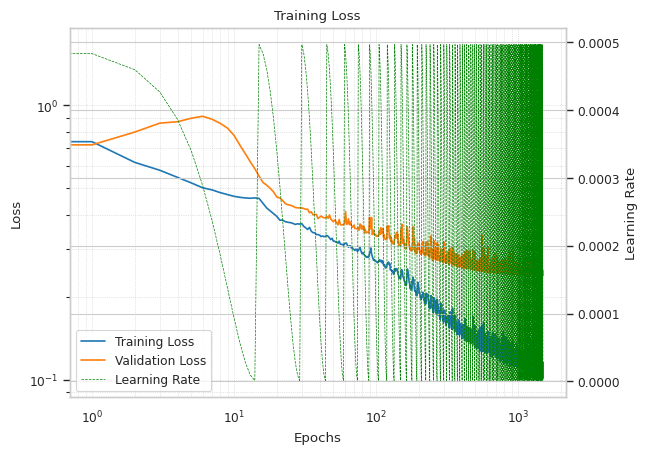

In [68]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.loglog(metrics["training_loss"], label="Training Loss")
l2 = ax1.loglog(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--", linewidth=0.5)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [l.get_label() for l in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

## Evaluating the model on test set (at $t=1.0$)

In [69]:
dataset_test = PDEDatasetAll2All("data/test_sol.npy", device=DEVICE, time_pairs=[(0, 4)])
test_data_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [70]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt).squeeze(-1)
        # prediction = fno(input).squeeze(-1)

        loss = torch.sum(relative_l2_error(prediction, target))
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(dataset_test)

print(rf"Test relative L2 error (only predictions at t=1.0): {test_relative_l2}")

 70%|███████   | 90/128 [00:00<00:00, 144.90it/s]

100%|██████████| 128/128 [00:00<00:00, 145.54it/s]

Test relative L2 error (only predictions at t=1.0): 0.20942721294704825
